In [266]:
import numpy as np
import pandas as pd
import math as m
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

# Import data

In [267]:
training_set = pd.read_csv("Training Set.csv")
training_label = pd.read_csv("Training Set Labels.csv")

all_data = pd.merge(training_set, training_label, how="left", on="id")
print(all_data.shape)
all_data.head()

(59400, 41)


,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,3/14/11,Roman,1390,Roman,34.938093,-9.856322,none,0,...,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,3/6/13,Grumeti,1399,GRUMETI,34.698766,-2.147466,Zahanati,0,...,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2/25/13,Lottery Club,686,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,1/28/13,Unicef,263,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,7/13/11,Action In A,0,Artisan,31.130847,-1.825359,Shuleni,0,...,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional


# Cleansing & transform

In [268]:
# Drop columns
feature_list = ['amount_tsh', 'date_recorded', 'gps_height', 'longitude', 'latitude', 'basin', 'region', 'lga', 
                'population', 'extraction_type_group', 'extraction_type_class', 'payment_type', 'water_quality',
                'quantity', 'source_type', 'source_class', 'waterpoint_type', 'status_group', 'id']

all_data = all_data[feature_list]
# print(all_data.shape)

In [269]:
# Remove outliers
all_data = all_data[all_data["longitude"] != 0]

In [270]:
# Tranform datetime first
date_recorded = pd.to_datetime(all_data["date_recorded"])
time_delta = (date_recorded - date_recorded.min()).astype('timedelta64[D]').astype(int) + 1
all_data["time_difference"] = time_delta
all_data = all_data.drop("date_recorded", axis=1)

In [271]:
# Generate dummy
categorical = ['basin', 'region', 'lga', 'extraction_type_group', 'extraction_type_class', 'payment_type',
               'water_quality', 'quantity', 'source_type', 'source_class', 'waterpoint_type']

for item in categorical:
    dummy = pd.get_dummies(all_data[item], prefix=item)
    all_data = all_data.join(dummy.ix[:, :])
    all_data = all_data.drop(item, axis=1)

In [272]:
# Function for feature transform
def transform(data):
    # Add column "population_0", "gps_height_0" and "amount_tsh_0"
    data['population_0'] = data['population'].apply(lambda x: 1 if x == 0 else 0)
    data['gps_height_0'] = data['gps_height'].apply(lambda x: 1 if x == 0 else 0)
    data['amount_tsh_0'] = data['amount_tsh'].apply(lambda x: 1 if x == 0 else 0)

    # Transform extremely skewed columns "population" and "amount_tsh"
    data['population'] = data['population'].apply(lambda x: m.log2(x + 1) if x < 5000 else m.log2(5000))
    data['amount_tsh'] = data['amount_tsh'].apply(lambda x: m.log2(x + 1) if x < 5000 else m.log2(5000))

    # Standardize continuous variables
    #continuous = ["gps_height", "longitude", "latitude", "time_difference"]
    #continuous = ['population', 'amount_tsh', "gps_height", "longitude", "latitude", "time_difference"]
    #scalar = preprocessing.StandardScaler()
    #scalar.fit(clean_data[continuous])
    #data[continuous] = scalar.transform(data[continuous])
        
    return data


In [274]:
# Transform and split data
all_data = transform(all_data)
train, cv = train_test_split(all_data, test_size=0.2)

In [276]:
y_train = train['status_group']
x_train = train.drop(['status_group'], axis=1)
y_cv = cv['status_group']
x_cv = cv.drop(['status_group'], axis=1)

# Fit model

In [244]:
# Fit logistic regression model
#model = LogisticRegression(penalty='l1', C=0.5, multi_class='ovr')
#model.fit(x_train.as_matrix(), y_train.as_matrix())

#y_pred = model.predict(x_test.as_matrix())
#accuracy = accuracy_score(y_test.as_matrix(), y_pred)
#accuracy

In [277]:
# Fit random forest
model = RandomForestClassifier(n_estimators=15, max_depth=None)
model.fit(x_train, y_train)

y_cv_pred = model.predict(x_cv)
accuracy = accuracy_score(y_cv, y_cv_pred)
accuracy

0.79423511026219829

# Plot accuracy against n_estimators

In [281]:
accuracy_cv = np.zeros(40)
accuracy_train = np.zeros(40)
for i in range(1, 41):
    model = model = RandomForestClassifier(n_estimators=i, max_depth=None)
    model.fit(x_train, y_train)

    y_cv_pred = model.predict(x_cv)
    y_train_pred = model.predict(x_train)
    accuracy_cv[i - 1] = accuracy_score(y_cv, y_cv_pred)
    accuracy_train[i - 1] = accuracy_score(y_train, y_train_pred)

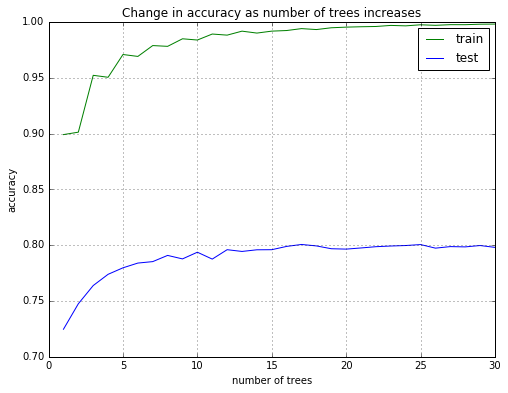

In [300]:
fig = plt.figure(figsize=(8,6))

plt.plot(np.linspace(1, 40, 40), accuracy_train, label='train', color='green')
plt.title('Change in accuracy as number of trees increases')
plt.xlim(0, 30)
plt.ylabel("accuracy")

plt.plot(np.linspace(1, 40, 40), accuracy_cv, label='test', color='blue')
plt.xlabel("number of trees")
plt.legend()
plt.grid()

plt.show()